In [3]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma, multivariate_normal, t, gamma
from numpy.linalg import cholesky


np.random.seed(200)

# Nombre d'observations
nombre_observations = 50

# Matrice de modèle simulée
X = np.column_stack([np.random.uniform(0, 10, nombre_observations), np.random.uniform(0, 10, nombre_observations)])

# Vrais coefficients beta
vrais_coefficients_beta = np.array([-50, 10])

# Vraie valeur de phi
vraie_phi = 10000
matrice_identite = np.eye(nombre_observations)  # Matrice identité utilisée pour la matrice de covariance

# Simuler la variable dépendante pour la régression
y = multivariate_normal.rvs(mean=np.dot(X, vrais_coefficients_beta),
                            cov=vraie_phi * matrice_identite)

# valeurs initiales
n,p = X.shape


beta_sampled = np.ones(p)
eta_sampled = np.ones(p)
zeta_sampled = 1
sigma_sampled = 1

nu = 1   # on se cantonne au cas nu = 1 qui est la meilleure valeur selon l'article mais on pourrait changer la valeur

print(n,p)

# On fait une fonction d'échantillonnage pour chaque paramètre : 

50 2


**Fonction qui sample les eta :** 

In [4]:
import numpy as np
from scipy.stats import gamma

def sample_eta_j(eta_j, m_j, ν=1):
    # Calcul de la valeur des paramètres de la distribution Gamma
    shape = (1 + ν) / 2
    scale = 1 / m_j
    
    # Génération de η_{t+1,j} à partir de la distribution Gamma inverse
    eta_tplus1_j = gamma.ppf(np.random.rand(), shape, scale=scale)
    
    return eta_tplus1_j

# Calcul de m_j 

def sample_m_tj(zeta,beta,sigma_sq,j):
    m_tj = (zeta*(beta[j])**2)*sigma_sq
    return m_tj


# Exemple d'utilisation

m_j = sample_m_tj(zeta_sampled,beta_sampled,sigma_sampled,0)
print(m_j)
eta_sampled2 = sample_eta_j(eta_sampled, m_j, 1)
print("Échantillon η_t+1,j :", eta_sampled2)


1.0
Échantillon η_t+1,j : 1.8842569995831986


**Fonction qui sample les zeta (ou xi dans l'article) :** 

In [7]:

def calculate_likelihood(y, zeta, eta, beta, sigma_sq):   
    """
    Calcul de la vraisemblance de y sachant zeta et eta.
    
    Arguments :
    y : Vecteur des observations.
    X : Matrice des prédicteurs.
    beta: Échantillon de beta.
    sigma_sq : Échantillon de sigma_sq.
    zeta : Valeur de zeta_t+1.
    eta : Vecteur des valeurs eta_t+1.

    Returns :
    log_likelihood : Log de la vraisemblance de y sachant zeta et eta.
    """

    # On calcule d'abord M_zeta_eta : 
    M_zeta_eta = np.eye(n) + 1/zeta * X@np.diag(1/eta)@X.T

    log_likelihood = -1/2 * np.log(np.linalg.det(M_zeta_eta)) - (1+n)/2 * np.log(1 + y.T@M_zeta_eta@y)
    
    return log_likelihood


def sample_zeta(zeta_previous, eta_tplus1, beta, sigma, sigma_mrth=0.8): 
    """
    Échantillonne la valeur de zeta_t+1 conditionnellement à zeta_previous et eta_t+1.

    Arguments :
    zeta_previous : Valeur zeta_t.
   eta_tplus1 : Valeur échantillonnée de eta_t+1.
    y : Vecteur de données.
    X : Matrice de design.
    beta : Vecteur de coefficients beta_t.
    sigma_sq : Variance sigma_t^2.
    sigma_mrth : Écart-type de la proposition normale = 0.8 selon l'article.

    Returns :
    zeta_sampled : Valeur échantillonnée de zeta_t+1.
    """

    # Proposition d'un nouvel échantillon de log(zeta_t+1)
    log_zeta_proposed = np.random.normal(np.log(zeta_previous), sigma_mrth)
    
    
    # Calcul des termes de probabilité a priori
    prior_current = -0.5 * zeta_previous ** 2
    prior_proposed = -0.5 * np.exp(2 * log_zeta_proposed)

    # On calcule la vraisemblance conditionnelle des données
    log_likelihood = (calculate_likelihood(y, np.exp(log_zeta_proposed), eta_sampled, beta, sigma)) # cf fonction calculate_likelihood au dessus
    
    # Log-probabilité du log-posterior pour les valeurs actuelles et proposées
    log_posterior_current = log_likelihood + prior_current
    log_posterior_proposed = log_likelihood + prior_proposed
    
    # Calcul du ratio de probabilité
    acceptance_ratio = np.exp(log_posterior_proposed - log_posterior_current)
    
    
    # Acceptation ou rejet de la proposition
    if np.random.uniform(0, 1) < acceptance_ratio:
        zeta_sampled = np.exp(log_zeta_proposed)
    else:
        zeta_sampled = zeta_previous

    return zeta_sampled



if __name__ == "__main__":
    # Exécution de l'algorithme pour échantillonner zeta
    new_zeta_sampled = sample_zeta(zeta_sampled, eta_sampled,beta_sampled, sigma_sampled)
    # Affichage des résultats
    print("zeta_sampled:", new_zeta_sampled )



zeta_sampled: 0.4595838865840563


**Fonction qui sample les sigma :** 

In [8]:
def sample_sigma_sq(zeta, eta, sigma):
    """
    Échantillonne la valeur de sigma_t+1^2 conditionnellement à zeta_t+1, et eta_t+1.

    Arguments :
    zeta : Valeur zeta_t+1.
    eta : Vecteur de valeurs eta_t+1.

    Returns :
    sigma_sq_sampled : Valeur échantillonnée de sigma_t+1^2.
    """
    
    # Calcul de M
    eta = np.array(eta)
    M = np.eye(n) + zeta**(-1) * X @ np.diag(1/eta) @ X.T
    
    # Calcul de y^T M^-1 y
    y_M_inv_y = y.T @ np.linalg.inv(M) @ y
        
        
    # Échantillonnage de sigma_t+1^2
    sigma_sq_sampled = 1 / np.random.gamma((1 + n) / 2, (y_M_inv_y + 1) / 2)
    
    return sigma_sq_sampled

if __name__ == "__main__":
    # Exécution de l'algorithme pour échantillonner zeta
    sigma_sampled2 = sample_sigma_sq(zeta_sampled, eta_sampled, sigma_sampled)
    # Affichage des résultats
    print("sigma_sampled:", sigma_sampled2 )

sigma_sampled: 2.0625909537782918e-07


**Fonction qui sample les béta :** 

In [10]:
def sample_beta(zeta, eta, sigma_sq):
    """
    Échantillonne la valeur de beta_t+1 conditionnellement à y, X, zeta_t+1, eta_t+1, et sigma_t+1^2.

    Arguments :
    y : Vecteur de réponse.
    X : Matrice de design.
    zeta : Valeur zeta_t+1.
    eta : Vecteur de valeurs eta_t+1.
    sigma_sq : Variance sigma_t+1^2.

    Returns :
    beta_sampled : Valeur échantillonnée de beta_t+1.
    """
    
    # Calcul de Sigma
    eta = np.array(eta)
   
    Sigma = np.linalg.inv(X.T @ X + zeta * np.diag(1/eta))

    
    # Calcul de mu
    mu = Sigma @ X.T @ y
    
    # Échantillonnage de beta_t+1
    beta_sampled = np.random.multivariate_normal(mu, sigma_sq * Sigma)
    
    return beta_sampled

if __name__ == "__main__":
    # Exécution de l'algorithme pour échantillonner zeta
    beta_sampled2 = sample_beta(zeta_sampled, eta_sampled,sigma_sampled)
    # Affichage des résultats
    print("beta_sampled:", beta_sampled2 )

beta_sampled: [-52.59165432  13.72963154]


**On recompile tout maintenant : pour faire notre block gibbs sampling** 

In [13]:
def blocked_gibbs_sampler(X, y, n_iter, burn_in = 600):
    """
    Réalise un échantillonnage de Gibbs en blocs pour estimer les paramètres d'un modèle linéaire bayésien.
    
    Arguments :
    X : Matrice de design.
    y : Vecteur de réponse.
    n_iter : Nombre d'itérations de l'algorithme.
    burn_in : Nombre d'itérations à brûler = 600 pour nu = 1 selon l'article
    
    Returns :
    betas : Liste des valeurs échantillonnées des coefficients beta.
    sigmas_squared : Liste des valeurs échantillonnées des variances sigma^2.
    etas :  Liste des valeurs échantillonnées de eta.
    zetas : Liste des valeurs échantillonnées de zeta.
    """
    # valeurs initiales
    n,p = X.shape

    beta_sampled = np.ones(p)
    eta_sampled = np.ones(p)
    zeta_sampled = 1
    sigma_sampled = 1

    nu = 1   # on se cantonne au cas nu = 1 qui est la meilleure valeur selon l'article mais on pourrait changer la valeur

    betas = []
    sigmas_squared = []
    etas = []
    zetas = []
    
    for _ in range(n_iter):
        # Étape 1 : Échantillonnage de eta_t+1
        eta_sampled2 = []
        for j in range (0,p):
            m_tj = sample_m_tj(zeta_sampled,beta_sampled,sigma_sampled,j)
            eta_sampled_j = sample_eta_j(eta_sampled, m_j, 1)
            eta_sampled2.append(eta_sampled_j) 
        eta_sampled = eta_sampled2
       
        # Étape 2 : Échantillonnage de zeta_t+1
        zeta_sampled = sample_zeta(zeta_sampled, eta_sampled, beta_sampled, sigma_sampled,0.8)
   
        # Étape 3 : Échantillonnage de sigma_t+1^2
        sigma_sampled = sample_sigma_sq(zeta_sampled, eta_sampled, sigma_sampled)
        
            
        # Étape 4 : Échantillonnage de beta_t+1
        beta_sampled = sample_beta(zeta_sampled, eta_sampled, sigma_sampled)

        # Sauvegarde des échantillons après la période de brûlage
        if _ >= burn_in:
            betas.append(beta_sampled)
            sigmas_squared.append(sigma_sampled)
            etas.append(eta_sampled)
            zetas.append(zeta_sampled)
    
    return betas, sigmas_squared, etas, zetas

if __name__ == "__main__":
    # Exécution de l'algorithme pour échantillonner zeta
    betas, sigmas_squared, etas, zetas= blocked_gibbs_sampler(X,y,100, 6)




    

betas: [[-52.58699671  13.7481507 ]
 [-52.6129588   13.7698236 ]
 [-52.37495354  13.57012959]
 [-52.59201572  13.74952257]
 [-52.550538    13.69894539]
 [-52.61338794  13.76921668]
 [-52.60755736  13.75910314]
 [-52.5859415   13.74685282]
 [-52.46489055  13.64855638]
 [-52.58016193  13.7294326 ]
 [-52.32492669  13.526918  ]
 [-52.54252393  13.70996944]
 [-39.03753496   2.62846217]
 [-52.57811862  13.73836199]
 [-52.45630197  13.59349338]
 [-52.52083927  13.67603853]
 [-52.58609986  13.73933249]
 [-52.54565933  13.69200975]
 [-51.42562628  12.7919817 ]
 [-52.25168651  13.46954626]
 [-52.60081217  13.75958805]
 [-52.6114006   13.76848194]
 [-52.59951823  13.7560167 ]
 [-52.54011833  13.6805599 ]
 [-52.53311668  13.7005701 ]
 [-52.43110893  13.6083338 ]
 [-52.48309484  13.62364872]
 [-52.6106013   13.76784122]
 [-52.53417077  13.70554999]
 [-52.61121935  13.76507418]
 [-52.59598837  13.75630644]
 [-52.61784374  13.77305883]
 [-52.612576    13.76995117]
 [-52.61890657  13.7745732 ]
 [-52.6

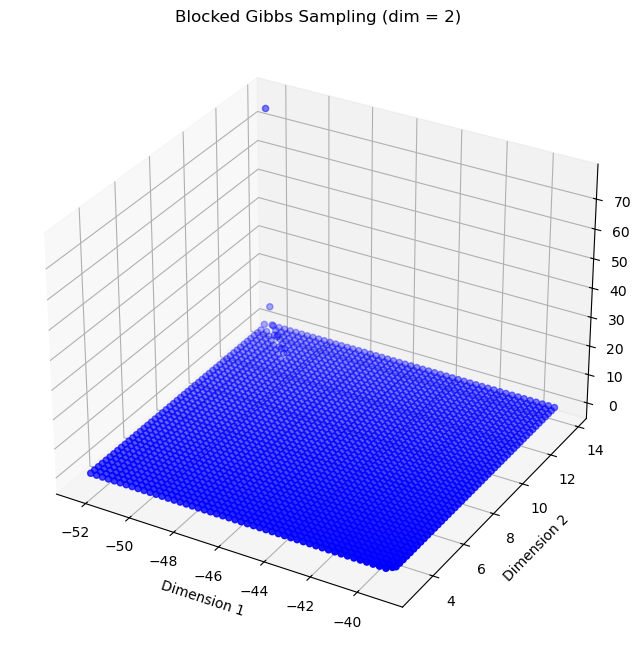

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

betas = np.array(betas)
print( "betas:", betas)
samples = betas
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=50)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.scatter(xpos, ypos, dz, c='b', marker='o')

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Frequency')
ax.set_title('Blocked Gibbs Sampling (dim = 2)')
path = "/home/onyxia/work/Monte-Carlo/"
plt.savefig(path + 'test bgs.png')
plt.show()


